In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, auc

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

import tensorflow as tf
from tensorflow.keras import layers, losses, metrics
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [2]:
df = pd.read_csv('HIGGS_6M.csv', header=None)
df.shape

(6000000, 29)

In [3]:
cols = list(df.columns)
cols.remove(0)

X = df[cols]
y = df[0]

In [4]:
TEST_SIZE = 50000
train = df.iloc[:-TEST_SIZE]
test = df.iloc[-TEST_SIZE:]

X = train[cols]
y = train[0]

X_test = test[cols]
y_test = test[0]

X.shape, y.shape, X_test.shape, y_test.shape

((5950000, 28), (5950000,), (50000, 28), (50000,))

In [5]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state=0)

X_train.shape, y_train.shape, X_val.shape, y_val.shape

((4760000, 28), (4760000,), (1190000, 28), (1190000,))

There are multiple techniques that one can use to reduce the dimensions of the data:

1. Principal Component Analysis (PCA)
2. Autoencoders 
3. Singular Value Decomposition (SVD)

**We will work with the 1st and 2nd approach.** 

3rd approach involves creation of matrices which is **practically difficult in our case where the dimension of data is extremely large**.

### Approach 1: Principal Component Analysis (PCA)

PCA aims to **maximize the variance of linear combinations of variables** under a constraint that the **components should be orthonormal**.

In [6]:
pca = PCA(n_components = 2)
pca_data = pca.fit_transform(X)

sum(pca.explained_variance_ratio_)

0.21238514999842378

We notice that the first two components can explain **roughly 21% of variance**. Let's visualize the first two components of PCA. 

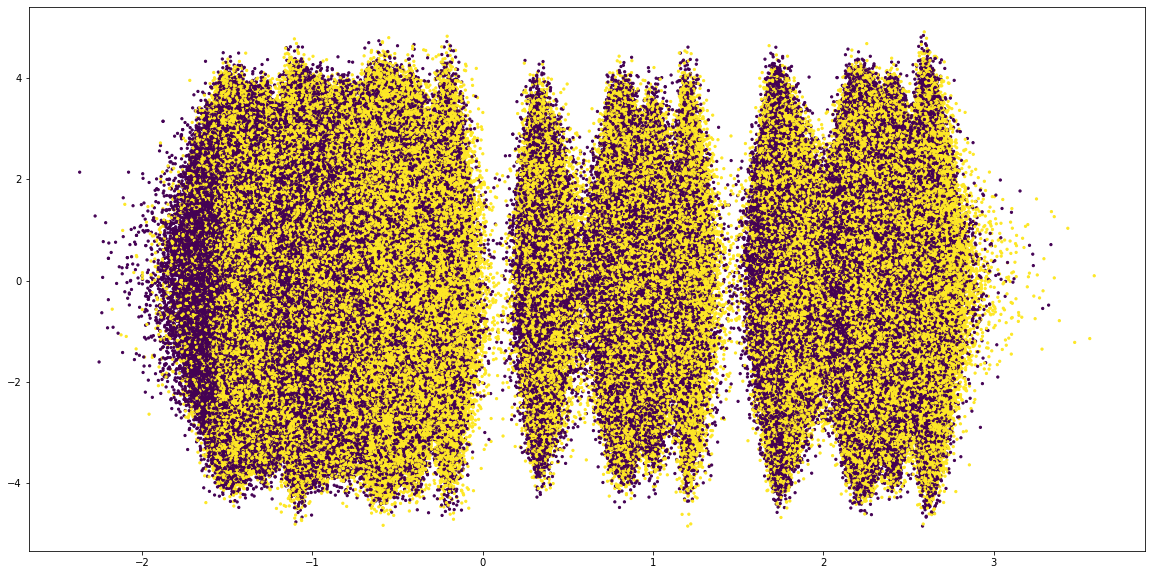

In [7]:
fig = plt.figure(figsize = (20, 10))

plt.scatter(pca_data[:, 0], pca_data[:, 1], s=5, c= y)
plt.show()

As expected, the visualization **does not reveal significant amount of information**. 

Let's increase number of principal components such that they explain **at least 90% of variance**.

In [8]:
%%time

pca = PCA(n_components = 16)
pca.fit(X)

print('Variance explained by 16 components:', 100*sum(pca.explained_variance_ratio_).round(3),'%')

pca = PCA(n_components = 25)
pca.fit(X)
print('Variance explained by 25 components:', 100*sum(pca.explained_variance_ratio_).round(3),'%')

Variance explained by 16 components: 90.3 %
Variance explained by 25 components: 99.7 %
Wall time: 1min 23s


**90% variance is explained by 16 components.**

**Let's assess LGBM classifier performance for 16 and above components, as it gave the best results in the previous task.**

In [9]:
def find_pca_performance(clf, X, y, X_test, y_test, n_components):
    
    pca = PCA(n_components = n_components)

    pca_train = pca.fit_transform(X)
    pca_test = pca.transform(X_test)
    
    clf.fit(pca_train, y)
    y_pred = clf.predict(pca_test)
    
    return roc_auc_score(y_test, y_pred)

clf = LGBMClassifier()

MIN_COMPONENTS = 16
MAX_COMPONENTS = 25
scores = list(map(lambda x: find_pca_performance(clf, X, y, X_test, y_test, x), [MIN_COMPONENTS, MAX_COMPONENTS]))

results = pd.DataFrame(scores, index=[MIN_COMPONENTS, MAX_COMPONENTS], 
                       columns=['roc_auc']).rename_axis('n_components').reset_index()

results

,n_components,roc_auc
0,16,0.630245
1,25,0.680779


We notice that the AUROC score **improves marginally with increasing number of principal components**, which is logical as with more number of components, larger variance gets captured and hence larger information content. 

### Approach 2: Autoencoders

Learning the distribution of data in lower-dimensioned/constrained space of one class and aiming to **minimize the reconstruction loss.** Naturally, reconstruction loss for trained class data should be **lesser** compared to other class data. 

**We train the model on data-points of Class 0 from train dataset and learn its distribution through the embeddings.** We now reconstruct the data from test set for both classes - 0 and 1, and we check for reconstruction loss. **Ideally, for a good model reconstruction loss for class 0 data should be lesser than that of class 1 data. This approach is also commonly used for anomaly detection.** 

For a certain threshold on reconstruction loss, we can label the test data-points such that **if reconstruction loss if higher than threshold, then the data-point should be labelled as 1, otherwise 0.** 

Based on different thresholds for reconstruction loss, we label the data-points, **calculate FPR (False Positive Rate) and TPR (True Positive Rate) and find ROC metrics.**

In [10]:
train_zero_idx = y_train[y_train==0].index
val_zero_idx = y_val[y_val==0].index

test_zero_idx = y_test[y_test==0].index
test_one_idx = y_test[y_test==1].index

X_train_zero = X_train.loc[train_zero_idx]
X_val_zero = X_val.loc[val_zero_idx]

X_train_zero.shape, X_val_zero.shape

((2238349, 28), (559859, 28))

In [11]:
X_test_zero = X_test.loc[test_zero_idx]
X_test_one = X_test.loc[test_one_idx]

X_test_zero.shape, X_test_one.shape

((23447, 28), (26553, 28))

In [12]:
class Autoencoder(Model):
    def __init__(self, embedding_dim, output_dim):
        super(Autoencoder, self).__init__()
        
        self.embedding_dim = embedding_dim
        self.output_dim = output_dim
        
        self.fc1 = tf.keras.Sequential(layers.Dense(embedding_dim, activation='relu'))
        self.fc2 = tf.keras.Sequential(layers.Dense(output_dim, activation='linear'))
        
    def call(self, x):
        
        embedding = self.fc1(x)
        output = self.fc2(embedding)

        return output

In [13]:
def reconstruction_loss(actual, predicted):
    return np.mean((actual-predicted)**2, axis=1)

lrop = ReduceLROnPlateau(monitor='val_loss', factor = 0.1, patience = 3)
estop = EarlyStopping(monitor='val_loss', patience = 5)

#### Calculating ROC metrics 

**False Positive Rate (FPR)** and **True Positive Rate (TPR)** for a range of thresholds on reconstruction loss

In [14]:
def find_outcome(actual_label, predicted_label):
    
    if (actual_label==predicted_label):
        if (actual_label == 1):
            return 'TP'
        else:
            return 'TN'
        
    else:
        if (actual_label == 1):
            return 'FN'
        else:
            return 'FP'
        
def calculate_roc_metrics(y_test, y_score, threshold):
    
    y_pred = (y_score>=threshold)*1
    outcomes = np.array(list(map(lambda x,y: find_outcome(x,y), y_test, y_pred)))
    
    tp = sum(outcomes=='TP')
    tn = sum(outcomes=='TN')
    fp = sum(outcomes=='FP')
    fn = sum(outcomes=='FN')
    
    if tp==0:
        tpr=0
    else:
        tpr = tp/(tp+fn)
    
    if fp==0:
        fpr = 0
    else:
        fpr = fp/(fp+tn)
    
    return fpr, tpr        

**Optimizing embedding dimension with AUROC**

In [15]:
def find_optimum_embedding(Autoencoder, embedding_dim, output_dim):
    
    model = Autoencoder(embedding_dim, output_dim)
    
    model.compile(optimizer = 'adam', loss = losses.MeanSquaredError())
    
    history = model.fit(X_train_zero, X_train_zero, epochs = 10, shuffle = True,
              validation_data = (X_val_zero, X_val_zero), callbacks = [lrop, estop])
    
    y_pred_zero = model.call(X_test_zero.values).numpy()
    loss_zero = reconstruction_loss(X_test_zero, y_pred_zero)

    y_pred_one = model.call(X_test_one.values).numpy()
    loss_one = reconstruction_loss(X_test_one, y_pred_one)

    test_loss = pd.concat([loss_zero, loss_one]).sort_index()    

    N_DATAPOINTS = 100
    thresholds = np.linspace(min(test_loss), max(test_loss), N_DATAPOINTS)

    roc_metrics = np.array(list(map(lambda x: calculate_roc_metrics(y_test.values, test_loss.values, x), thresholds)))
    
    fpr = roc_metrics[:,0]
    tpr = roc_metrics[:,1]
    
    return fpr, tpr

In [16]:
output_dim = X_train.shape[1]

embedding_dim = 10
fpr1, tpr1 = find_optimum_embedding(Autoencoder, embedding_dim, output_dim)

embedding_dim = 15
fpr2, tpr2 = find_optimum_embedding(Autoencoder, embedding_dim, output_dim)

embedding_dim = 20
fpr3, tpr3 = find_optimum_embedding(Autoencoder, embedding_dim, output_dim)

Epoch 1/10
69949/69949 [==============================] - 48s 679us/step - loss: 0.2543 - val_loss: 0.2251
Epoch 2/10
69949/69949 [==============================] - 48s 685us/step - loss: 0.2249 - val_loss: 0.2247
Epoch 3/10
69949/69949 [==============================] - 49s 697us/step - loss: 0.2246 - val_loss: 0.2245
Epoch 4/10
69949/69949 [==============================] - 44s 634us/step - loss: 0.2247 - val_loss: 0.2245
Epoch 5/10
69949/69949 [==============================] - 46s 652us/step - loss: 0.2246 - val_loss: 0.2245
Epoch 6/10
69949/69949 [==============================] - 44s 626us/step - loss: 0.2244 - val_loss: 0.2243
Epoch 7/10
69949/69949 [==============================] - 44s 628us/step - loss: 0.2248 - val_loss: 0.2244
Epoch 8/10
69949/69949 [==============================] - 43s 620us/step - loss: 0.2246 - val_loss: 0.2245
Epoch 9/10
69949/69949 [==============================] - 44s 631us/step - loss: 0.2247 - val_loss: 0.2243
Epoch 10/10
69949/69949 [============

**Plotting ROC Curve against range of thresholds on reconstruction loss.**

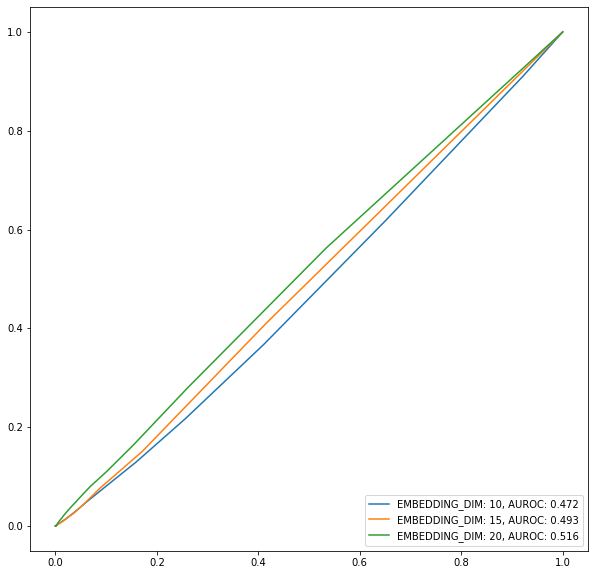

In [17]:
fig=plt.figure(figsize=(10,10))

roc_auc1 = auc(fpr1, tpr1)
roc_auc2 = auc(fpr2, tpr2)
roc_auc3 = auc(fpr3, tpr3)

plt.plot(fpr1, tpr1, label='EMBEDDING_DIM: 10, AUROC: %0.3f' %roc_auc1)
plt.plot(fpr2, tpr2, label='EMBEDDING_DIM: 15, AUROC: %0.3f' %roc_auc2)
plt.plot(fpr3, tpr3, label='EMBEDDING_DIM: 20, AUROC: %0.3f' %roc_auc3)

plt.legend(loc="lower right")
plt.show()

It is expected that as **embedding dimension increases, the model performance increases**.

**Choosing embedding dimension as 20.**

In [18]:
embedding_dim = 20
output_dim = X_train.shape[1]

model = Autoencoder(embedding_dim, output_dim)

In [19]:
model.compile(optimizer = 'adam', loss = losses.MeanSquaredError())

history = model.fit(X_train_zero, X_train_zero, epochs = 10, shuffle = True,
          validation_data = (X_val_zero, X_val_zero), callbacks = [lrop, estop])

Epoch 1/10
69949/69949 [==============================] - 60s 837us/step - loss: 0.0682 - val_loss: 0.0297
Epoch 2/10
69949/69949 [==============================] - 52s 742us/step - loss: 0.0295 - val_loss: 0.0293
Epoch 3/10
69949/69949 [==============================] - 61s 869us/step - loss: 0.0295 - val_loss: 0.0294
Epoch 4/10
69949/69949 [==============================] - 55s 785us/step - loss: 0.0295 - val_loss: 0.0294
Epoch 5/10
69949/69949 [==============================] - 56s 802us/step - loss: 0.0295 - val_loss: 0.0294
Epoch 6/10
69949/69949 [==============================] - 62s 886us/step - loss: 0.0293 - val_loss: 0.0292
Epoch 7/10
69949/69949 [==============================] - 64s 911us/step - loss: 0.0293 - val_loss: 0.0292
Epoch 8/10
69949/69949 [==============================] - 60s 851us/step - loss: 0.0292 - val_loss: 0.0292
Epoch 9/10
69949/69949 [==============================] - 61s 874us/step - loss: 0.0293 - val_loss: 0.0292
Epoch 10/10
69949/69949 [============

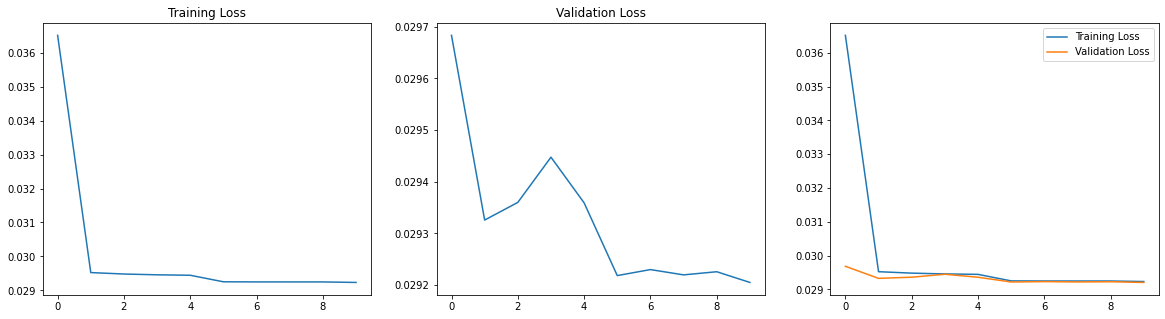

In [20]:
fig=plt.figure(figsize=(20,5))

plt.subplot(131)
plt.plot(history.history["loss"], label="Training Loss")
plt.title('Training Loss')

plt.subplot(132)
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title('Validation Loss')

plt.subplot(133)

plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

#### As training and validation loss are close to each other, our model is not overfitting.

In [21]:
y_pred_zero = model.call(X_test_zero.values).numpy()
loss_zero = reconstruction_loss(X_test_zero, y_pred_zero)

y_pred_one = model.call(X_test_one.values).numpy()
loss_one = reconstruction_loss(X_test_one, y_pred_one)

test_loss = pd.concat([loss_zero, loss_one]).sort_index()

In [22]:
N_DATAPOINTS = 100
thresholds = np.linspace(min(test_loss), max(test_loss), N_DATAPOINTS)

roc_metrics = np.array(list(map(lambda x: calculate_roc_metrics(y_test.values, test_loss.values, x), thresholds)))

fpr = roc_metrics[:,0]
tpr = roc_metrics[:,1]

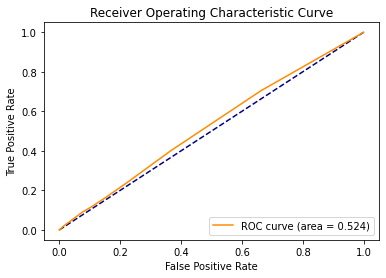

In [23]:
roc_auc = auc(fpr, tpr)

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.title('Receiver Operating Characteristic Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.3f)' % roc_auc)
plt.legend(loc="lower right")
plt.show()

Our approach with autoencoders has not been able to give us comparable results with that of PCA.

Since **approach 1 - PCA gave better results**, we will go ahead with it.

Let's consider **number of principal components as 20**, so that there isn't significant reduction in model performance.

In [24]:
n_components = 20
pca = PCA(n_components = n_components)

pca_train = pca.fit_transform(X)
pca_test = pca.transform(X_test)

clf = LGBMClassifier()

clf.fit(pca_train, y)
y_pred = clf.predict(pca_test)

y_train_pred = clf.predict(pca_train)
y_test_pred = clf.predict(pca_test)

y_train_score=clf.predict_proba(pca_train)[:,1]
y_test_score=clf.predict_proba(pca_test)[:,1]

In [26]:
%%time

N_DATAPOINTS = 10
thresholds = np.linspace(0, 1, N_DATAPOINTS)

train_roc_metrics = np.array(list(map(lambda x: calculate_roc_metrics(y.values, y_train_score, x), thresholds)))
test_roc_metrics = np.array(list(map(lambda x: calculate_roc_metrics(y_test.values, y_test_score, x), thresholds)))

train_fpr = train_roc_metrics[:,0]
train_tpr = train_roc_metrics[:,1]

test_fpr = test_roc_metrics[:,0]
test_tpr = test_roc_metrics[:,1]

Wall time: 7min 53s


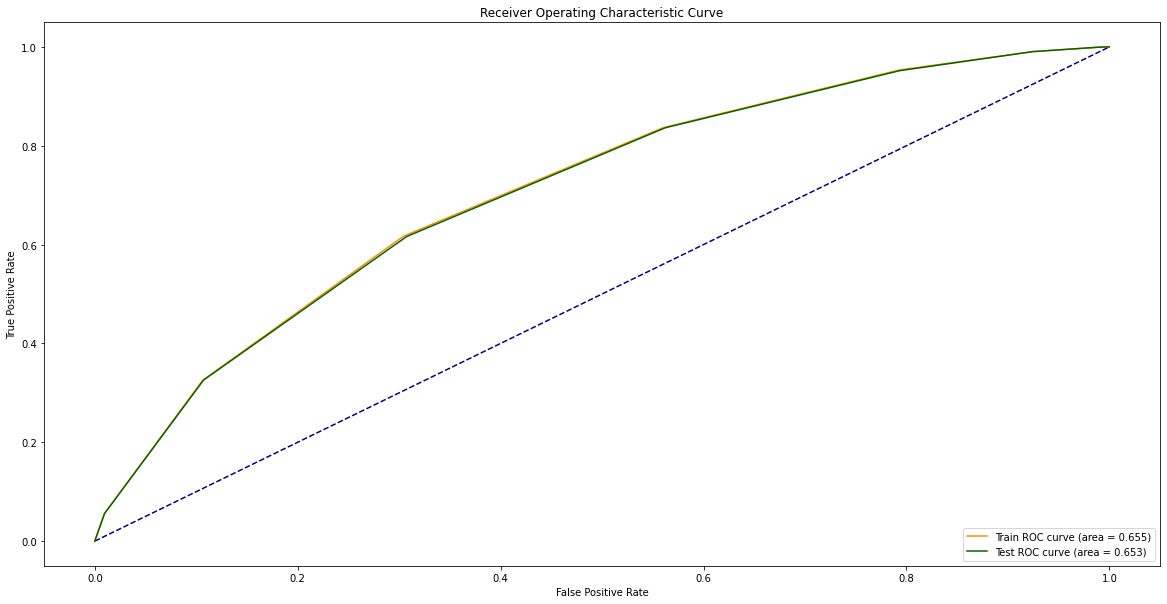

In [29]:
fig = plt.figure(figsize=(20,10))

train_roc_auc = roc_auc_score(y, y_train_pred)
test_roc_auc = roc_auc_score(y_test, y_test_pred)

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.title('Receiver Operating Characteristic Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.plot(train_fpr, train_tpr, color='darkorange', label='Train ROC curve (area = %0.3f)' % train_roc_auc)
plt.plot(test_fpr, test_tpr, color='darkgreen', label='Test ROC curve (area = %0.3f)' % test_roc_auc)
plt.legend(loc="lower right")
plt.show()

As we notice that the training ROC Curve and testing ROC Curve are close to each other, we can say that the model is **not overfitted.**

### Saving the model

In [31]:
import pickle

with open('clf_task2.pkl', 'wb') as f:
    pickle.dump(clf, f)